In [1]:
import spacy
# python -m spacy download en_core_web_sm
# python -m spacy download pl_core_news_sm
import re
import tarfile
import os
import matplotlib.pyplot as plt
import numpy as np
import regex
import pandas as pd
import morfeusz2
from elasticsearch_dsl import *
from elasticsearch_dsl import query
from elasticsearch import *
from elasticsearch.helpers import *

import os
import pickle

import spacy
from collections import Counter
from spacy.tokenizer import *
import string
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import pandas as pd
import time
import Levenshtein


1. Make sure the texts in the corpus does not contain HTML code.
2. Use SpaCy [tokenizer API](https://spacy.io/api/tokenizer) to tokenize the text from the cleaned law corpus.
3. Compute **frequency list** for each of the processed files.
4. Aggregate the result to obtain one global frequency list.
5. Reject all entries that are shorter than 2 characters or contain non-letter characters (make sure to include Polish
   diacritics).
6. Make a plot in a logarithmic scale (for X and Y):
   1. X-axis should contain the **rank** of a term, meaning the first rank belongs to the term with the highest number of
      occurrences; the terms with the same number of occurrences should be ordered by their name,
   2. Y-axis should contain the **number of occurrences** of the term with given rank.

In [2]:
nlp = spacy.load("pl_core_news_sm")
tokenizer = Tokenizer(nlp.vocab)


In [3]:
text = "Al)a ma-kota\ni psa"
print(text)
text1 = text.translate(str.maketrans('', '', string.punctuation))
print(text)


def preprocess(text):
    text = list(text)
    for i in range(len(text)):
        if text[i] in string.punctuation:
            text[i] = ' '
    return ''.join(text)

print(preprocess(text))

Al)a ma-kota
i psa
Al)a ma-kota
i psa
Al a ma kota
i psa


In [4]:

file_tokens = {}

i = 0
path="../data/ustawy"
for filename in os.listdir(path):
    with open(os.path.join(path, filename), 'r',encoding='utf-8') as f: # open in readonly mode
        text = f.read()
        # text = text.translate(str.maketrans('', '', string.punctuation))
        text = preprocess(text)
        text = text.lower()
        text = regex.sub(r'\s+', ' ',text)


        doc = tokenizer(text)
        words = [token.text for token in doc if token.is_stop != True and token.is_punct != True and (len(token.text) >1) and token.is_alpha and not token.is_digit ]

        file_tokens[f.name] = words
        word_freq = Counter(words)
        i+=1
        if i % 200 == 0:
            print(i)
    

200
400
600
800
1000


In [5]:
word_freq ={}
for filename, tokens in file_tokens.items():
    word_freq[filename] = Counter(tokens)

In [6]:
word_freq_total = Counter({})
for counting in word_freq.values():
    word_freq_total.update(counting)


In [7]:
word_freq_total.most_common(5)

[('art', 82963),
 ('ust', 53624),
 ('poz', 45245),
 ('nr', 44950),
 ('mowa', 28783)]

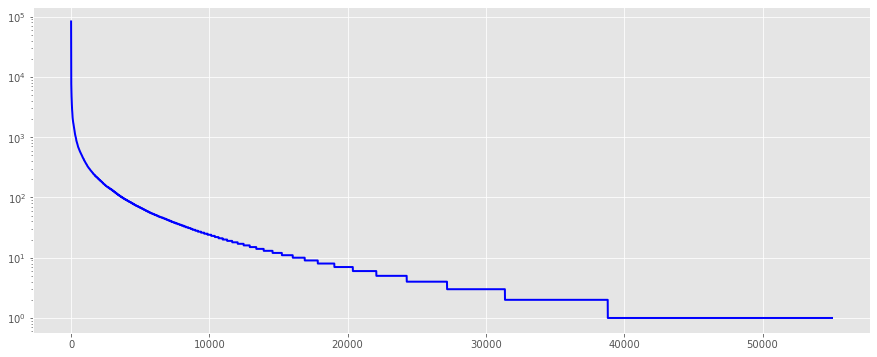

In [8]:
freq = [freq for (_,freq) in word_freq_total.most_common()]
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)

ax.plot(range(1,len(word_freq_total)+1),freq, color='blue', lw=2)

ax.set_yscale('log')

plt.show()


7. Install [Morfeusz](http://morfeusz.sgjp.pl/download/) (Binding dla Pythona) and use it to find all words that do not
  appear in that dictionary.


In [52]:
from morfeusz2 import *
#Obiekt utworzony bez podawania parametrów konstruktora będzie używał domyślnego słownika SGJP i domyślnych ustawień opcji.
morf = Morfeusz()

not_found = {}
for (token,freq) in word_freq_total.most_common():
#     print('!'+token+'!',(morf.analyse(token)))
    if 'ign' in (morf.analyse(token))[0][2]:
#         print(freq,token)
        not_found[token] =freq
        
        

In [53]:
morf.analyse("piws")

[(0, 1, ('piws', 'piws', 'ign', [], []))]

8. Find 30 words with the highest ranks that do not belong to the dictionary.

In [54]:
counter = Counter(not_found).most_common(30)
counter

[('poz', 45245),
 ('zm', 1072),
 ('późn', 1066),
 ('str', 516),
 ('gmo', 298),
 ('sww', 226),
 ('operacyjno', 209),
 ('skw', 195),
 ('rolno', 194),
 ('ex', 169),
 ('ike', 162),
 ('społeczno', 137),
 ('techniczno', 125),
 ('remediacji', 120),
 ('ure', 103),
 ('rozdz', 102),
 ('itp', 97),
 ('uke', 95),
 ('kn', 95),
 ('sanitarno', 88),
 ('charytatywno', 87),
 ('np', 85),
 ('cn', 83),
 ('pkwiu', 81),
 ('udt', 76),
 ('bswsg', 68),
 ('biobójczych', 63),
 ('bswp', 63),
 ('organizacyjno', 58),
 ('phs', 53)]

In [60]:
print('Total number of words that do not belong to the dictionary:', len(Counter(not_found).most_common()))

Total number of words that do not belong to the dictionary: 2805


9. Find 30 random words (i.e. shuffle the words) with 5 occurrences that do not belong to the dictionary.

In [59]:
import random
freq_5 = [token for (token,freq) in not_found.items() if freq==5 ]
random.shuffle(freq_5)
print(freq_5[0:30])
print('Total number of words with 5 occurrences that do not belong to the dictionary :', len(freq_5))

['sposb', 'rci', 'wlkp', 'cznika', 'metylofenetyloamina', 'inspekcyjno', 'zawart', 'wodno', 'wapnio', 'ponitracyjnego', 'denitracyjne', 'inci', 'ppkt', 'informacyjno', 'ami', 'nfośigw', 'regazyfikacyjnego', 'kpwig', 'schetyna', 'najmnie', 'heptanol', 'jed', 'eudravigilance', 'chelatującym', 'sięcy', 'organicz', 'odgazowywacze', 'agave', 'mieszkalno', 'rr']
Total number of words with 5 occurrences that do not belong to the dictionary : 56


# 10
10. Use Levenshtein distance and the frequency list, to determine the most probable correction of the words from
   lists defined in points 8 and 9. (**Note**: You don't have to apply the distance directly. Any method that is more efficient than scanning the
   dictionary will be appreciated.)

In [13]:
morf = Morfeusz()
analysis_result = morf.analyse("Ala ma kota")

print(analysis_result)


[(0, 1, ('Kot', 'Kot:Sf', 'subst:sg.pl:nom.gen.dat.acc.inst.loc.voc:f', ['nazwisko'], [])), (0, 1, ('Kot', 'kot:Sm1', 'subst:sg:nom:m1', ['nazwa_pospolita'], ['pot.,środ.'])), (0, 1, ('Kot', 'Kot:Sm1', 'subst:sg:nom:m1', ['nazwisko'], [])), (0, 1, ('Kot', 'kot:Sm2', 'subst:sg:nom:m2', ['nazwa_pospolita'], [])), (0, 1, ('Kot', 'Kot:Sm3', 'subst:sg:nom.acc:m3', ['nazwa_geograficzna'], [])), (0, 1, ('Kot', 'kota', 'subst:pl:gen:f', ['nazwa_pospolita'], [])), (1, 2, ('ma', 'mieć', 'fin:sg:ter:imperf', [], [])), (1, 2, ('ma', 'mój:A', 'adj:sg:nom.voc:f:pos', [], [])), (2, 3, ('Alę', 'Ala', 'subst:sg:acc:f', ['imię'], []))]


In [14]:
filename = '../data/sgjp-20211031.tab'
sjp =pd.read_csv(filename,skiprows=29,usecols=[0,1],header=None,delim_whitespace='\t')[1]

sjp = set(sjp)

In [61]:
import math



def find_suggestions(words):
    start = time.time()
    suggestions = {}
    min_distance = {}

    i = 0
    for word in words: # words with 5 ocurrences
        suggestions[word] = []
        min_distance[word] = math.inf 
        for dic in sjp:
            levenshtein = Levenshtein.distance(word,dic)
            if min_distance[word] >levenshtein:
                min_distance[word] = levenshtein
                suggestions[word] = [dic]
            elif min_distance[word] == levenshtein:
                suggestions[word].append(dic)                    
        i+=1
        if i%5==0:
            print(i)

    end = time.time() - start
    print("total time", end)
    return (min_distance,suggestions)

def print_suggestions(words):
    (min_distance,suggestions) = find_suggestions(words)
    for word, suggested in suggestions.items():
        print(word, min_distance[word] ,"--->",suggested)
        print(word, f'-->distance={min_distance[word]} ', suggested)

In [62]:
# print(suggestions)
top_30 = [token for (token,_) in counter]

print_suggestions(top_30)


5
10
15
20
25
30
total time 9.127793550491333
poz 1 ---> ['płoz', 'po', 'pod', 'pot', 'paz', 'oz']
poz -->distance=1  ['płoz', 'po', 'pod', 'pot', 'paz', 'oz']
zm 1 ---> ['em', 'km', 'om', 'izm', 'um', 'hm', 'im']
zm -->distance=1  ['em', 'km', 'om', 'izm', 'um', 'hm', 'im']
późn 1 ---> ['późno', 'późny']
późn -->distance=1  ['późno', 'późny']
str 1 ---> ['styr', 'itr', 'ster', 'syr', 'star', 'ser', 'sto']
str -->distance=1  ['styr', 'itr', 'ster', 'syr', 'star', 'ser', 'sto']
gmo 1 ---> ['śmo', 'go']
gmo -->distance=1  ['śmo', 'go']
sww 1 ---> ['suw', 'www']
sww -->distance=1  ['suw', 'www']
operacyjno 1 ---> ['operacyjny']
operacyjno -->distance=1  ['operacyjny']
skw 1 ---> ['ska', 'suw', 'ski']
skw -->distance=1  ['ska', 'suw', 'ski']
rolno 1 ---> ['Solno', 'Kolno', 'rolny', 'rośno', 'rojno', 'Dolno']
rolno -->distance=1  ['Solno', 'Kolno', 'rolny', 'rośno', 'rojno', 'Dolno']
ex 1 ---> ['ej', 'eł', 'Rex', 'em', 'eś', 'er', 'et', 'el', 'e', 'en', 'ee', 'eh', 'sex', 'eń']
ex -->distan

In [63]:
print_suggestions(freq_5)

5
10
15
20
25
30
35
40
45
50
55
total time 16.070964097976685
sposb 2 ---> ['spora', 'spory', 'spis', 'szos', 'społy', 'epos', 'szosa', 'stołb', 'opos', 'oposy', 'spoić', 'spisa', 'stos', 'sos', 'spona', 'spust', 'spot', 'snob', 'skos', 'spod', 'spoza']
sposb -->distance=2  ['spora', 'spory', 'spis', 'szos', 'społy', 'epos', 'szosa', 'stołb', 'opos', 'oposy', 'spoić', 'spisa', 'stos', 'sos', 'spona', 'spust', 'spot', 'snob', 'skos', 'spod', 'spoza']
rci 1 ---> ['ci']
rci -->distance=1  ['ci']
wlkp 2 ---> ['werp', 'wlec', 'wkup', 'wąkop', 'alko', 'wykup', 'zlep', 'Elka', 'wykap', 'wyka', 'elki', 'weka', 'slup', 'slip', 'wsyp', 'Ulka', 'lkm', 'Olki', 'ślep', 'wilk', 'wrap', 'Alka', 'elka', 'walka', 'wek', 'clip', 'wlot', 'klip', 'wikt', 'klep', 'ślip', 'ulep', 'wamp', 'wok', 'klop', 'alka', 'wlać', 'lep', 'wilki', 'wkop', 'wykop', 'klap', 'ulop', 'wlew', 'flip']
wlkp -->distance=2  ['werp', 'wlec', 'wkup', 'wąkop', 'alko', 'wykup', 'zlep', 'Elka', 'wykap', 'wyka', 'elki', 'weka', 'slup',

# ELASTICSEARCH

11. Load [SGJP dictionary](http://morfeusz.sgjp.pl/download/) (Słownik SGJP dane tekstowe) to ElasticSearch (one document for each form) 
   and use fuzzy matching to obtain the possible
   corrections of the 30 words with 5 occurrences that do not belong to the dictionary.

In [23]:
es = Elasticsearch("http://localhost:9200")
print(es.info())

connections.add_connection('python_client', es)
connections.create_connection(hosts=['localhost'])

# curl -X DELETE 'http://localhost:9200/_all'

{'name': 'x-dell', 'cluster_name': 'elasticsearch', 'cluster_uuid': 'hrJwCHZtSGm_1kBHAztvag', 'version': {'number': '7.10.1', 'build_flavor': 'default', 'build_type': 'deb', 'build_hash': '1c34507e66d7db1211f66f3513706fdf548736aa', 'build_date': '2020-12-05T01:00:33.671820Z', 'build_snapshot': False, 'lucene_version': '8.7.0', 'minimum_wire_compatibility_version': '6.8.0', 'minimum_index_compatibility_version': '6.0.0-beta1'}, 'tagline': 'You Know, for Search'}


<Elasticsearch([{'host': 'localhost'}])>

In [36]:
filename = '../data/sgjp-20211031.tab'
sjp =pd.read_csv(filename,skiprows=29,usecols=[0,1],header=None,delim_whitespace='\t')[1]

sjp = set(sjp)

In [37]:

# def gendata():
#     mywords = ['kot', 'mysz', 'baz']
#     for word in mywords:
#         yield {
#             "_index": "mywords1",
#             "word": word,
#         }

# bulk(es, gendata(),request_timeout=10000)

In [38]:
def gendata():
    i=0
    for word in sjp:
        if i%300000 ==0:
            print(i)
        i+=1
        yield {
            "_index": "sjp",
            "word": word,
        }
                

bulk(es, gendata(),request_timeout=10000 )

0
300000


(383709, [])

In [42]:
def get_suggestions_es(myword,myindex,fuzziness=1):
    result =es.search(index=myindex,
       query ={
            "fuzzy": {
                "word": {
                "value": myword,
                "fuzziness": fuzziness
                }
            }
        }
    )
    hits = result['hits']['hits']


    hits_number = len(hits)

    # print(hits_number)

    suggestions = [i['_source']['word'] for i in hits]
    # print(suggestions)
    return suggestions


print(get_suggestions_es('mysz','sjp'))


def get_suggestions_if_needed_es(word,index):
    for fuzziness in range(1,40):
        suggestions = get_suggestions_es(word,index,fuzziness=fuzziness)
        if len(suggestions)>1:
            break

    if word in suggestions:
        return ["Word belongs to the dictionary"]
    else:
        return (suggestions,fuzziness)
    


print(get_suggestions_if_needed_es('mysz','sjp'))

['misz-masz', 'mysz', 'wysz', 'mysi', 'kysz', 'mesz', 'myszy', 'MSZ']
['Word belongs to the dictionary']


In [43]:
def print_suggestions_es(words):
    start = time.time()

    for word in words:
        (suggestions,fuzziness) = get_suggestions_if_needed_es(word,'sjp')
        print(word, f'-->distance={fuzziness} ', suggestions)
    print(f'Total time={time.time()-start}')


In [44]:
print_suggestions_es(top_30)

poz -->distance=1  ['Pot', 'TOZ', 'Poe', 'płoz', 'POW', 'pot', 'ZOZ', 'paz', 'pod', 'po']
zm -->distance=1  ['powypasać:Vp~am~zę', 'pasać:Vi~am~zę', 'ZZ', 'ZMP', 'ZS', 'MZ', 'RM', 'ZOM', 'om', 'em']
późn -->distance=1  ['późno', 'Późna', 'późny']
str -->distance=1  ['Star', 'sto', 'SOR', 'STAR', 'syr', 'star', 'styr', 'itr', 'ster', 'ser']
gmo -->distance=1  ['śmo', 'WMO', 'GMC', 'MO', 'go', 'GM', 'Hauke:Sm1~go', 'Faure:Sm1~go', 'go-cart', 'Wilde:Sm1~go']
sww -->distance=1  ['suw', 'WSW', 'WWW', 'www', 'SW']
operacyjno -->distance=2  ['operacyjny', 'operacyjnie', 'operacyjka', 'operacyjność']
skw -->distance=1  ['suw', 'UKW', 'ska', 'PKW', 'SKS', 'ski', 'SW']
rolno -->distance=1  ['rolny', 'Solno', 'Rożno', 'Kolno', 'rośno', 'rojno', 'Dolno']
ex -->distance=1  ['el', 'et', 'EP', 'eł', 'Rex', 'em', 'eś', 'ej', 'er', 'Ed']
ike -->distance=1  ['IDE', 'Ikea', 'iże', 'IKEA', 'Nike', 'KE']
społeczno -->distance=1  ['społeczny', 'Sołeczno']
techniczno -->distance=2  ['techniczny', 'techniczka

In [45]:
print_suggestions_es(freq_5)

urt -->distance=1  ['hurt', 'gurt', 'Uri', 'nurt', 'URz', 'ura', 'UHT', 'ort', 'burt', 'furt']
zawart -->distance=1  ['Zawarta', 'Zawrat']
funkcjonalno -->distance=2  ['funkcjonalny', 'funkcjonalność', 'funkcjonalnie']
jed -->distance=1  ['jad', 'jen', 'ued', 'jod', 'jej', 'Ed', 'Błażej:Sm1~je~owie', 'Maciej:Sm1~je~owie', 'Siergiej:Sm1~je~owie']
schetyna -->distance=2  ['chatyna', 'chityna', 'cetyna']
cznika -->distance=2  ['Czacka', 'czajka', 'oznaka', 'panika', 'Annika', 'czamka', 'czniać', 'Gzinka', 'tunika', 'arnika']
nitracyjne -->distance=39  []
inci -->distance=2  ['Vinci', 'sini', 'inąd', 'inwit', 'iścić', 'wincik', 'dingi', 'nick', 'inba', 'Iłki']
rialnego -->distance=39  []
betezda -->distance=39  ['etezja']
ym -->distance=1  ['yo-yo', 'my', 'RM', 'om', 'em', 'cym', 'km', 'UM', 'DM', 'um']
inspekcyjno -->distance=2  ['inspekcyjny', 'inspekcyjność']
czych -->distance=1  ['chych', 'czuch', 'czmych', 'szych']
winopochodne -->distance=39  []
instrumen -->distance=39  ['instrument

In [46]:

print(Levenshtein.distance("AA","BA!"))

2


In [ ]:
freq_5

In [ ]:

s = Search(using=es, index="ustawa").query("match_all")[:3000].execute()
ids = [x.meta.id for x in s]

amount=0
for id in ids:
    s = es.termvectors(index="ustawa", fields="content", id =id,field_statistics=True)
    print(s['term_vectors']['content']['terms'])
    try:
        amount += s['term_vectors']['content']['terms']['ustawa']['term_freq']
    except KeyError:
        pass
    break
print(amount)


12. Compare the results of your algorithm and output of ES. 

In [ ]:
for word in top_30:
    (min_distance,suggestions) = find_suggestions(words)
    (suggestions_es,fuzziness_es) = get_suggestions_if_needed_es(word,'sjp')

13. Draw conclusions regarding:
   * the distribution of words in the corpus,
   * the number of true misspellings vs. the number of unknown words,
   * the performance of your method compared to ElasticSearch,
   * the results provided by your method compared to ElasticSearch,
   * the validity of the obtained corrections.